# A/B Test: Landing Page

This mock A/B test is being conducted using [this](https://www.kaggle.com/zhangluyuan/ab-testing) dataset from kaggle.  This dataset contains the following information: 
- User ID
- Time stamp of event
- Control vs. Treatment Group
- Landing Page
- Conversion (binary) 

Over 99% of the users in the control group are routed to the old landing page, and the same is true for treatment group users on the new page. I'm therefore unsure of why both columns are included in the dataframe, and I excluded the <1% of users that fell outside these groups. 

The aim of this test is to see if the new landing page for this website yielded more conversion amongst users than the old landing page. The null hypothesis is that there is no difference in conversion rate between the control and treatment group. The alternative hypothesis is that there is a difference between the groups. A one-tailed hypothesis would be that the treatment group has a higher conversion rate. 

Group size is being determined using [this calculator](https://www.optimizely.com/sample-size-calculator/?conversion=12&effect=5&significance=95). The conversion rate of the control group is 12%, and I am looking for a minimum detected change of 5%. Based on these metrics, the sample size for each group needs to be 50,000. 


## Part One: Cleaning & Examining Data

For cleaning the data, I eliminated redundant user ID's. Then, I looked at the number of users in the experimental and control groups to ensure that they are similar. I then used a groupby function to get a preliminary feel for the percentage of users who were converted in both groups. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/Users/Austen/Downloads/ab_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [2]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
print(data['user_id'].duplicated().sum())

3894


In [4]:
data = data.drop_duplicates(subset='user_id')
print(data['user_id'].value_counts(ascending=False))

630732    1
793302    1
840399    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64


In [5]:
data['landing_page'].value_counts()

new_page    145320
old_page    145264
Name: landing_page, dtype: int64

In [6]:
data['group'].value_counts()

treatment    145352
control      145232
Name: group, dtype: int64

In [7]:
data['converted'].sum()

34745

In [8]:
group = data.groupby(by=['group','landing_page']).count()
print(group)

                        user_id  timestamp  converted
group     landing_page                               
control   new_page         1006       1006       1006
          old_page       144226     144226     144226
treatment new_page       144314     144314     144314
          old_page         1038       1038       1038


In [9]:
group = data.groupby(by=['group']).mean()
print(group)

                 user_id  converted
group                              
control    788143.414241   0.120297
treatment  787866.452577   0.118843


## Part Two: Statistical Hypothesis Test 

First, I looked at the means of my samples, and the standard deviations, to ensure that these are similar. 
Because I am comparing proportions, I used a Z-test for significance testing. I also looked at the confidence intervals. 

In [10]:
from scipy import stats
control = data[data['group']=='control']
control = control[control['landing_page']=='old_page']['converted'].sample(n = 50000)
exp = data[data['group']=='treatment']
exp = exp[exp['landing_page']=='new_page']['converted'].sample(n = 50000)
means = [control.mean(),exp.mean()]
print(means)

[0.12018, 0.11718]


In [11]:
print(control.std(),exp.std())

0.32517515645812 0.321637865647662


In [12]:
import statsmodels.api
statsmodels.stats.weightstats.ztest(control,exp)
# first value is z-score, second value is p-value. 

(1.466682146842869, 0.14246254171418882)

In [13]:
confidence_level = 0.95
ct_degrees_freedom = control.size - 1
ctrl_mean = np.mean(control)
ctrl_standard_error = stats.sem(control)
ci_control = stats.t.interval(confidence_level, ct_degrees_freedom, ctrl_mean, ctrl_standard_error)
print(ci_control)

(0.11732969745782476, 0.12303030254217523)


In [14]:
confidence_level = 0.95
exp_degrees_freedom = exp.size - 1
exp_mean = np.mean(exp)
exp_standard_error = stats.sem(exp)
ci_exp = stats.t.interval(confidence_level, exp_degrees_freedom, exp_mean, exp_standard_error)
print(ci_exp)

(0.1143607033596897, 0.11999929664031031)


(0.11, 0.13)

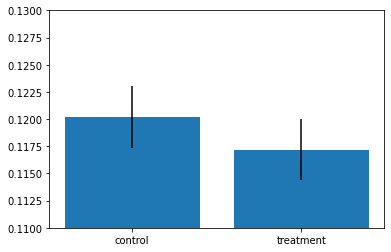

In [15]:
x_pos = np.arange(len(means))
ci = [ci_control,ci_exp]
ci_chart = [means[i] - ci[i][1] for i in range(len(ci))]
labels = ['control','treatment']
plt.bar(x_pos,means,yerr=ci_chart)
plt.xticks([r for r in range(len(means))], ['control','treatment'])
plt.ylim([0.11,0.13])

## Conclusion 

The p-value is > 0.05, and the confidence intervals overlap almost completely. This means that the null hypothesis cannot be rejected. This means that the new landing page does not generate a significantly different number of conversions from the old landing page. 